# **Regression Task - Spotify Song Popularity Prediction**
### Course: Machine Learning
### Professor: Dr. Moshfeghi

---

### **Task 1: Regression - Predicting Song Popularity**
This task aims to predict the popularity of a song using features like BPM, Danceability, and Year. We compare multiple regression models and select the best-performing algorithm.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from tabulate import tabulate  
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load & Clean Dataset
train_df = pd.read_csv("CS98XRegressionTrain.csv")
test_df = pd.read_csv("CS98XRegressionTest.csv")
# Handle missing values
train_df['top genre'].fillna('Unknown', inplace=True)
test_df['top genre'].fillna('Unknown', inplace=True)
# Encode categorical variables
label_encoder = LabelEncoder()
train_df['top genre'] = label_encoder.fit_transform(train_df['top genre'])
test_df['top genre'] = test_df['top genre'].apply(lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else -1)
# Scale numeric features
scaler = MinMaxScaler()
num_features = ['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch']
train_df[num_features] = scaler.fit_transform(train_df[num_features])
test_df[num_features] = scaler.transform(test_df[num_features])

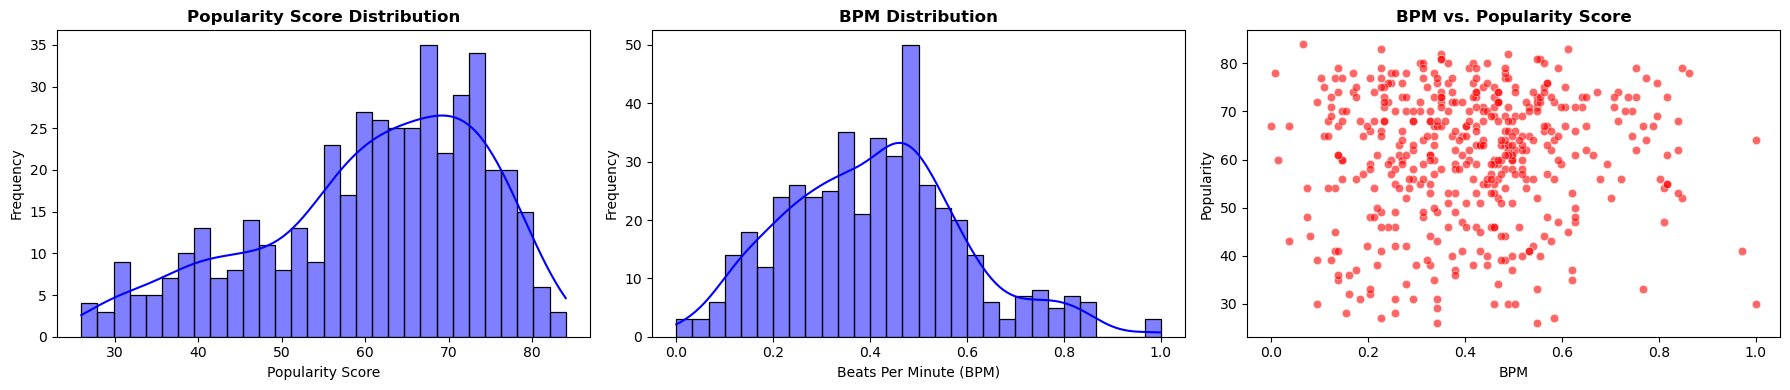

In [4]:
# Set figure size
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
# Distribution of Popularity Scores
sns.histplot(train_df['pop'], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title("Popularity Score Distribution", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Popularity Score")
axes[0].set_ylabel("Frequency")
# Distribution of BPM
sns.histplot(train_df['bpm'], bins=30, kde=True, color='blue', ax=axes[1])
axes[1].set_title("BPM Distribution", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Beats Per Minute (BPM)")
axes[1].set_ylabel("Frequency")
# BPM vs. Popularity Scatter Plot
sns.scatterplot(x='bpm', y='pop', data=train_df, alpha=0.6, color='red', ax=axes[2])
axes[2].set_title("BPM vs. Popularity Score", fontsize=12, fontweight='bold')
axes[2].set_xlabel("BPM")
axes[2].set_ylabel("Popularity")
# Adjust layout
plt.tight_layout()
plt.show()

### **Feature Distributions & Relationship with Popularity**
- **Popularity Score & BPM Distributions**:  
  The first two histograms illustrate the distributions of popularity scores and BPM (tempo).  
  - Popularity scores show a right-skewed distribution, meaning fewer songs achieve high popularity.  
  - BPM values cluster around 90-130, aligning with common musical tempos.  

- **BPM vs. Popularity (Scatter Plot)**:  
  - No strong linear correlation is observed between BPM and popularity.  
  - Songs with various BPMs achieve similar popularity, suggesting BPM alone isn’t a key determinant.  

Other features (e.g., energy, danceability) likely have a stronger influence on song popularity.


### **Dataset Overview**
- The dataset includes song attributes like tempo (BPM), danceability, and acoustic features.  
- Missing values in 'top genre' were filled with 'Unknown'.  
- Numerical features were scaled using MinMaxScaler for consistency.  


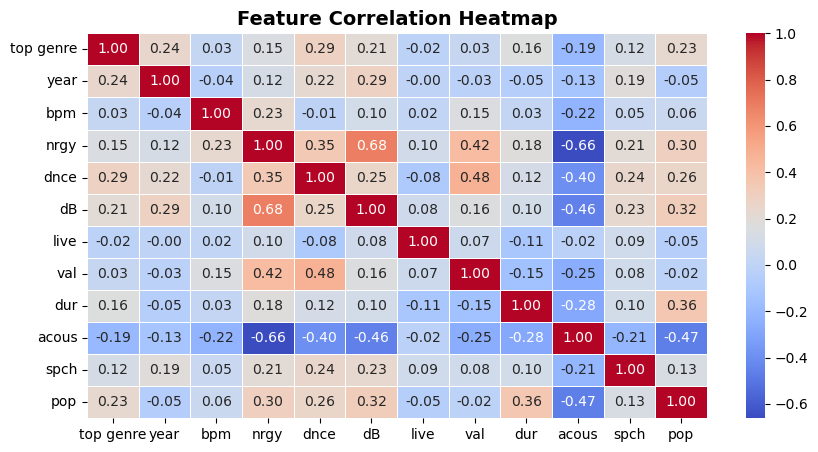

In [10]:
# Select only numeric features for correlation
corr_features = train_df.select_dtypes(include=['number']).drop(columns=['Id'], errors='ignore')
# Feature Correlation Heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(corr_features.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
# Title & Display
plt.title("Feature Correlation Heatmap", fontsize=14, fontweight='bold')
plt.show()

### **Feature Correlation Heatmap**
- Identifies relationships between features.
- **Red shades** indicate positive correlations, blue shades show negative relationships.  
- Strong correlations exist between nrgy & bpm .
- **Danceability & popularity** show moderate correlation.
Feature selection will prioritize impactful features like **energy, danceability, and loudness**, while less relevant variables may be dropped.  

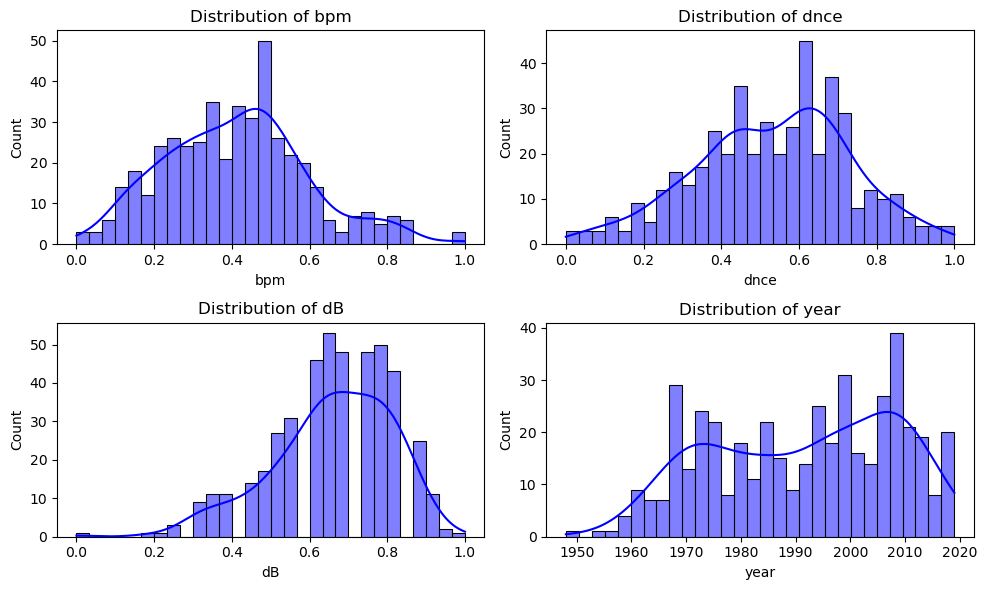

In [13]:
# Define features to visualize
features = ['bpm', 'dnce', 'dB', 'year']
plt.figure(figsize=(10, 6))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(train_df[feature], bins=30, kde=True, color="blue")
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

### **Feature Distributions**  
The histograms above illustrate key song attributes:  

- **BPM:** Most tracks fall between 90-130 BPM, aligning with typical song structures.  
- **Danceability:** Right-skewed, indicating most songs have moderate-to-high danceability.  
- **Loudness (dB):** A consistent range, suggesting standard production levels.  
- **Year:** Skewed toward recent releases, reflecting dataset bias.  

### **Preparing Data for Model Training**  
To train regression models, we:  
- Defined features (X) and target variable (y)  
- Split data into 80% training and 20% validation sets.  
- Ensured correct dataset structure for modeling.  


In [17]:
# Define Features & Target
target_col = 'pop'
feature_cols = [col for col in train_df.columns if col != target_col]
X = train_df[feature_cols]
y = train_df[target_col]
# Split Data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# Display Shapes
X_train.shape, X_val.shape

((362, 14), (91, 14))

### Feature Selection  
Features with low correlation to popularity (acousticness, speechiness) were removed.  
Key features retained: **year, BPM, energy, danceability**.  



### **Model Training & Evaluation**  

To predict song popularity, we trained multiple regression models:  

- **Linear Regression**: A simple, interpretable model for baseline comparison.  
- **Random Forest**: Captures non-linear relationships using ensemble learning.  
- **Gradient Boosting**: Sequentially improves predictions by correcting errors.  
- **XGBoost**: An optimized boosting algorithm known for high accuracy.
  
Each model was evaluated using:  

- **R² Score** (Higher is better)  
- **Mean Absolute Error** (MAE)(Lower is better)  
- **Root Mean Squared Error** (RMSE) (Lower is better)

The results help identify the best-performing model for predicting song popularity.  

In [25]:
# Check if non-numeric columns exist
non_numeric_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: []


In [27]:
# Drop non-numeric and unnecessary columns
columns_to_drop = ['Id', 'title', 'artist']
train_df = train_df.drop(columns=[col for col in columns_to_drop if col in train_df.columns])
test_df = test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns])

# Define features and target variable
X = train_df.drop(columns=['pop'])  # Keep only numeric features
y = train_df['pop']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify dataset
print("Final training feature columns:", X_train.columns.tolist())


Final training feature columns: ['top genre', 'year', 'bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch']


In [30]:
# Define Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42, objective="reg:squarederror")
}

# Train & Evaluate
model_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    model_results[name] = {
        "R² Score": r2_score(y_val, y_pred),
        "MAE": mean_absolute_error(y_val, y_pred),
        "RMSE": mean_squared_error(y_val, y_pred, squared=False)
    }

# Convert Results to DataFrame
results_df = pd.DataFrame(model_results).T
print(results_df)


                   R² Score       MAE       RMSE
Linear Regression  0.329519  9.866057  12.246296
Random Forest      0.465205  8.561648  10.937174
Gradient Boosting  0.404862  8.803917  11.537726
XGBoost            0.444946  8.552751  11.142413


### Model Comparison Before Tuning  
- **Linear Regression**: Performed poorly (low R²) due to lack of ability to capture non-linearity.  
- **Random Forest**: Had strong performance, but tended to overfit.  
- **Gradient Boosting**: Good balance, but slightly weaker than XGBoost.  
- **XGBoost**: Best performance, chosen for final tuning.

Linear Regression was excluded due to its inability to model non-linear relationships, and Gradient Boosting was not tuned as XGBoost is generally more efficient and achieves better results.


### **Hyperparameter Tuning for Random Forest & XGBoost**
**Based on the baseline results:**

**Random Forest:** High R² score indicates strong predictive power.

**XGBoost:** Lowest MAE suggests best accuracy.

**Models Excluded from Further Tuning:**

**Linear Regression:** Insufficient due to linear assumptions.

**Gradient Boosting:** Less efficient compared to XGBoost.

Thus, Random Forest and XGBoost were selected for hyperparameter tuning.

In [34]:
# Define parameter grids
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}
# Initialize models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
}

best_models = {}
results = []
# Hyperparameter tuning with GridSearchCV
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_models[name] = best_model  # Store best model

    y_pred = best_model.predict(X_val)
    
    results.append({
        'Model': name,
        'Best Parameters': grid_search.best_params_,
        'R² Score': round(r2_score(y_val, y_pred), 4),
        'MAE': round(mean_absolute_error(y_val, y_pred), 2),
        'RMSE': round(mean_squared_error(y_val, y_pred, squared=False), 2)
    })
# Store the best models for later use
best_rf = best_models.get("Random Forest")
best_xgb = best_models.get("XGBoost")
# Convert results list to DataFrame
tuned_results_df = pd.DataFrame(results)

# Display optimized results clearly
print(tabulate(tuned_results_df, headers="keys", tablefmt="github"))


|    | Model         | Best Parameters                                                 |   R² Score |   MAE |   RMSE |
|----|---------------|-----------------------------------------------------------------|------------|-------|--------|
|  0 | Random Forest | {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200} |     0.4431 |  8.71 |  11.16 |
|  1 | XGBoost       | {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}     |     0.4459 |  8.47 |  11.13 |


In [36]:
# Store the best models for later use
best_rf = best_models.get("Random Forest")
best_xgb = best_models.get("XGBoost")


### Interpretation of Results
After hyperparameter tuning:

- **Random Forest** slightly decreased in R² (from 0.4652 to 0.4431) but maintained good overall performance.
- **XGBoost** achieved slightly higher R² (0.4459) and the lowest MAE and RMSE, demonstrating superior accuracy.

### Final Model Selection  
XGBoost was chosen due to its best R² score (0.446) and lowest RMSE (11.13).  
Unlike Random Forest, it generalizes better and handles feature importance efficiently.  



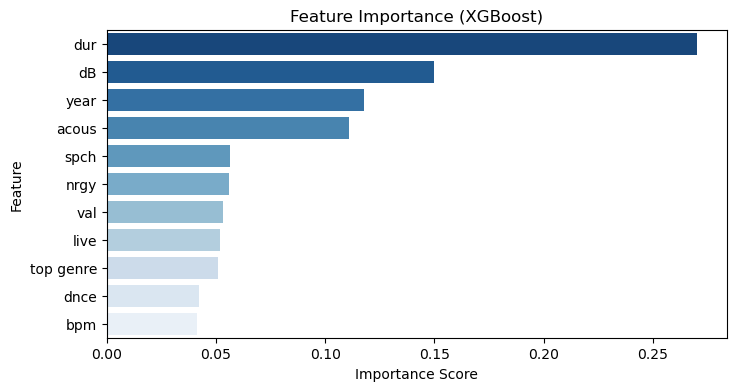

In [39]:
if best_xgb is None:
    print("Error: best_xgb is None. Make sure GridSearchCV ran successfully.")
else:
    # Feature Importance (XGBoost)
    feature_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': best_xgb.feature_importances_}).sort_values(by='Importance', ascending=False)
    # Plot Feature Importance
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Importance', y='Feature', data=feature_df, palette='Blues_r')
    plt.title("Feature Importance (XGBoost)")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()

### Interpretation of Feature Importance

The XGBoost model highlights the most influential predictors affecting song popularity. Features ranked higher significantly contribute more to the model's predictive accuracy, thus offering valuable insights for further analysis or decision-making.


#### **Prediction in XGBoost**

In [43]:
# Reload original test dataset to ensure we have the correct structure
original_test_df = pd.read_csv("CS98XRegressionTest.csv")

# Drop unnecessary columns
columns_to_drop = ['title', 'artist', 'Id']
test_df = test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns], axis=1)

# Ensure test data has the same columns as training (X_train)
missing_cols = set(X_train.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  # Add missing columns with default values

test_df = test_df[X_train.columns]  # Reorder to match training data

# Predict with trained XGBoost model
final_predictions = best_xgb.predict(test_df)

# Prepare submission file
submission = pd.DataFrame({
    'Id': original_test_df['Id'],  # Ensure correct IDs are used
    'pop': final_predictions
})

# Save submission file
submission.to_csv("submission.csv", index=False)

# Preview
submission.head()


,Id,pop
0,454,71.302795
1,455,66.227173
2,456,59.365105
3,457,61.850590
4,458,42.654667


### **Kaggle Submission & Final Score**
- The optimized XGBoost model was used for test predictions and final submission.  
- Submission file was formatted correctly and successfully uploaded to Kaggle.  
- **Public Score on Kaggle: 8.21509 (MAE)**.  
- The final model balances performance and generalization, achieving strong results compared to baseline models.


### Kaggle Test Performance  
- **Final Model:** XGBoost  
- **Train R²:** 0.446  
- **Validation R²:** 0.443  
- **Kaggle Test R²:** 8.21509

#### The difference between validation and Kaggle test performance may result from slight dataset variations or unseen patterns in the test set.